# CNN model for Rice leaf disease prediction

This dataset has 119 rice leaf images of three different classes: 
1. Bacterial leaf blight --> 40 images
2. Brown spot --> 40 images
3. Leaf smut --> 39 images

The images are of different sizes: (3081 X 897), (766 X 250), (617X244), (1530 X 371), (1480 X 279), etc.
The CNN can't handle varied size images. Hence these need to be resized to the same size beforing feeding it to the model which will do in the later steps.

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

Here, the image data is split into 3 categories:
1. Train
2. Validation
3. Test

## Reading image data

In [2]:
train_dir = '/content/drive/MyDrive/Rice leaf disease data/train'

In [3]:
val_dir = '/content/drive/MyDrive/Rice leaf disease data/validation'

In [4]:
## Defining some parameters for future use

BATCH_SIZE = 8            # the number of training samples in one forward/backward pass
IMG_WIDTH = 790           # image width
IMG_HEIGHT = 230          # image height
CHANNELS = 3              # number of channels: as these are coloured images with RGB channels

In [5]:
## Let's load the images from the disc using 'tf.keras.preprocessing.image_dataset_from_directory'
# image_dataset_from_directory: yields batches of images from the subdirectories/classes together with their labels

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,                             # directory where train data is stored
                                                                 labels = 'inferred',                   # labels: 'inferred' --> labels are generated from the directory structure
                                                                 label_mode = 'int',                    # labels are encoded as integers
                                                                 seed = 42,                             # random seed for shuffling and transformations
                                                                 shuffle = True,                        # shuffles the data
                                                                 image_size = (IMG_HEIGHT, IMG_WIDTH),  # resize images to this 'H' X 'W'
                                                                 batch_size = BATCH_SIZE)

val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,                                 # directory where validation data is stored
                                                               labels = 'inferred',
                                                               label_mode = 'int',
                                                               seed = 42,
                                                               shuffle = True,
                                                               image_size = (IMG_HEIGHT, IMG_WIDTH),
                                                               batch_size = BATCH_SIZE)

Found 98 files belonging to 3 classes.
Found 12 files belonging to 3 classes.


In [6]:
## We can get the class names in the 'class_names' attribute on these datasets

class_names = train_data.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

As can be seen above, each dataset has further 3 sub categories/classes/directories: Baterial leaf blight, brown spot & leaf smut.

In [7]:
print(type(train_data))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


Tensorflow BatchDataset is a Dataset that batches/stacks consecutive elements of a dataset into a single element from its input.

In [8]:
## To get the shape of train_data images & labels in train_data

for image_batch, labels_batch in train_data:     
  print(image_batch.shape)                       # image_batch is a tensor of the shape (8, 230, 790, 3) i.e. This is a batch of 32 images of shape 230 x 790 x 3. 
  print(labels_batch.shape)                      # The label_batch is a tensor of the shape (8,), these are corresponding labels to the 8 images.
  break                                          

(8, 230, 790, 3)
(8,)


## **Visualizing the data**

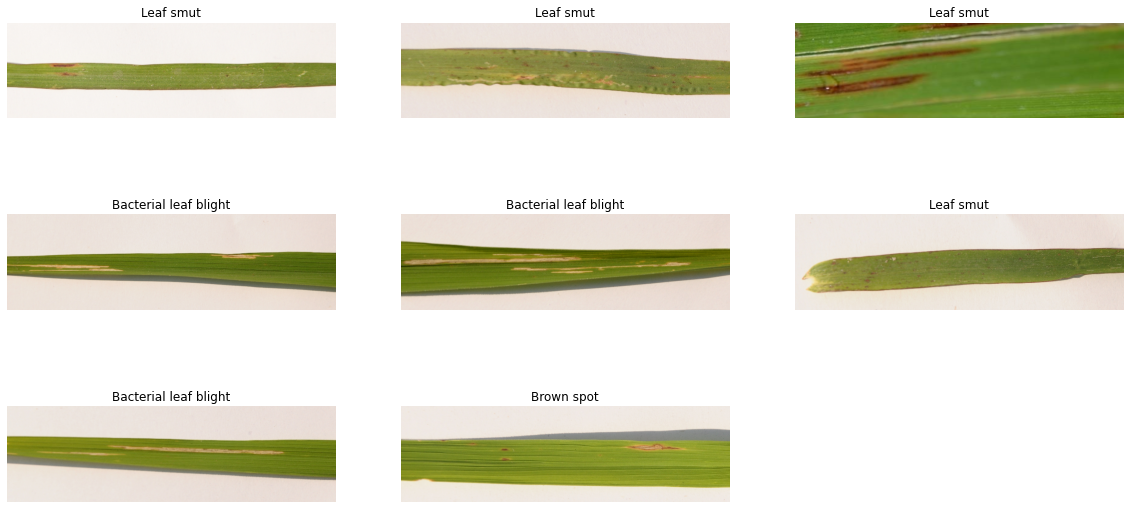

In [9]:
## Let's see how our train data looks like

plt.figure(figsize=(20, 10))
for images, labels in train_data.take(1):                 # The .take(1) method is used to take the images from the 1st batch i.e. take 8 images from the 1st batch
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))     # converting tensor to numpy array. Further converting numpy array to uint8 (0-255) to display the image
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Data Augmentation

* As our dataset is very small, we need to perform **data augmentation** to expand the size of your dataset. Apart from this this technique makes our model robust & help generalize well.
* Here, Keras **ImageDataGenerator** class has been used which generate batches of tensor image data with real-time data augmentation.

In [10]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=30,          # degree of image roatation
                                   rescale=1/255,              # The image pixels are in [0, 255] range which isn't ideal for a neural network. Hence need rescaling to standardize
                                   width_shift_range=0.1,      # shifts image along the width by fraction of total width
                                   height_shift_range=0.1,     # shifts image along the height by fraction of total height
                                   shear_range=0.1,            # distortes the image
                                   zoom_range=0.2,             # zooms the image by given factor
                                   horizontal_flip=True,       # flips the image horizontally
                                   vertical_flip=True,         # flips the image vertically
                                   fill_mode='nearest')        # fills the area near the border of augmented images with the nearest pixels

validation_datagen = ImageDataGenerator(rotation_range=30,
                                        rescale=1/255,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        shear_range=0.1,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255)  

* The ImageDataGenerator class has three methods **flow()**, **flow_from_directory()** and **flow_from_dataframe()** to read the images from a big numpy array and folders containing images.
* Here we will use **flow_from_directory()** as we have multiple images in our training set from each sub directory/class.

In [11]:
## flow_from_directory: takes the path to a directory & generates batches of augmented data

train_gen = train_datagen.flow_from_directory(train_dir,
                                              batch_size = BATCH_SIZE,                # No. of images to be yielded from the generator per batch
                                              target_size = (IMG_HEIGHT, IMG_WIDTH),  # resize images to this 'H' X 'W'
                                              shuffle = True,
                                              seed = 42,
                                              class_mode = 'sparse')                  # determines type of labels. "sparse"--> 1D integer labels

Found 98 images belonging to 3 classes.


In [12]:
val_gen = validation_datagen.flow_from_directory(val_dir,
                                                 batch_size = BATCH_SIZE,  
                                                 target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                 shuffle = True,
                                                 seed = 42,
                                                 class_mode = 'sparse')

Found 12 images belonging to 3 classes.


## CNN model buidling

In [13]:
from tensorflow.keras import models, layers, optimizers, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [14]:
input_shape = BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNELS 
n_classes = 3                                                       # As there are 3 classes(bacterial leaf blight, brown spot & leaf smut)

Here, we'll be using a stack of 7 convolution layers with a ReLU activation followed by max-pooling layers. Further we have added flatten layer to convert 3D feature maps to 1D feature vectors. We end the model with a units=n_classes and a softmax activation, which is perfect for a multi-class classification problem.

In [15]:
## Defining a sequential CNN model for image classification

model = models.Sequential()

### Input layer: 
# As input, a CNN takes tensors of shape (image_height, image_width, colour_channels), ignoring the batch size
# Here 'same' padding is used to add zero values in the outer frame of the images so the filter can cover the edge of the matrix and make the inference with them too.
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation = 'relu', padding = 'same', 
                        input_shape=input_shape[1:], data_format='channels_last'))
model.add(layers.MaxPooling2D((2, 2)))

### Hidden layers
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=512, kernel_size=(3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=512, kernel_size=(3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=1024, kernel_size=(3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=2048, kernel_size=(3,3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())                                                                         # this converts our 3D feature maps to 1D feature vectors
model.add(layers.Dense(units=1024, activation = 'relu'))

### Output layer: 
# size of the output from the dense layer: 3 units as there are 3 classes
# using 'softmax' activation func as this is a multi-class classification problem
model.add(layers.Dense(n_classes, activation='softmax'))   

model.build(input_shape=input_shape[1:])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 230, 790, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 115, 395, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 115, 395, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 57, 197, 128)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 57, 197, 256)      295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 98, 256)      0

In [17]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss = 'sparse_categorical_crossentropy',        # As this is a classification problem & our labels are 'sparse': 1D int
              metrics = ['accuracy'])

## Training the model

In [18]:
history = model.fit(train_gen,                          # Generator data (augmented images) is used for training instead of original train dataset images
                    batch_size = BATCH_SIZE,
                    verbose = 1,                        # for verbose = 1--> shows the progress bar for each epoch
                    epochs = 100,
                    steps_per_epoch = 98//BATCH_SIZE,   # 98//8 = 12.25 ~ 12  steps_per_epoch
                    validation_data = val_gen,
                    validation_steps = 12//BATCH_SIZE)  # 12//8 = 1.5 ~ 1  validation_step (When the epoch ends, the validation generator will yield validation_steps batches)

Epoch 1/100
12/12 [==============================] - 27s 1s/step - loss: 1.1027 - accuracy: 0.2778 - val_loss: 1.0888 - val_accuracy: 0.3750
Epoch 2/100
12/12 [==============================] - 10s 780ms/step - loss: 1.0980 - accuracy: 0.3556 - val_loss: 1.0966 - val_accuracy: 0.3750
Epoch 3/100
12/12 [==============================] - 9s 775ms/step - loss: 1.1003 - accuracy: 0.2889 - val_loss: 1.0995 - val_accuracy: 0.2500
Epoch 4/100
12/12 [==============================] - 10s 785ms/step - loss: 1.0950 - accuracy: 0.4111 - val_loss: 1.1001 - val_accuracy: 0.3750
Epoch 5/100
12/12 [==============================] - 9s 769ms/step - loss: 1.0918 - accuracy: 0.4222 - val_loss: 1.0809 - val_accuracy: 0.3750
Epoch 6/100
12/12 [==============================] - 9s 769ms/step - loss: 1.0912 - accuracy: 0.3667 - val_loss: 1.0975 - val_accuracy: 0.2500
Epoch 7/100
12/12 [==============================] - 9s 768ms/step - loss: 1.0867 - accuracy: 0.3444 - val_loss: 1.0715 - val_accuracy: 0.6250

## Model evaluation

In [19]:
test_dir = '/content/drive/MyDrive/Rice leaf disease data/test'
test_gen = test_datagen.flow_from_directory(test_dir,
                                            seed = 42,
                                            shuffle = False,
                                            target_size = (IMG_HEIGHT, IMG_WIDTH),
                                            batch_size = 1,
                                            class_mode = 'sparse')

Found 9 images belonging to 3 classes.


In [20]:
scores = model.evaluate(test_gen, verbose=1)

9/9 [==============================] - 1s 42ms/step - loss: 0.4228 - accuracy: 0.7778


In [21]:
scores

[0.4228019714355469, 0.7777777910232544]

In [22]:
print('Test accuarcy: {:0.2f}%'.format(scores[1] * 100))

Test accuarcy: 77.78%


We got **Test accuracy** as **77.78%** which is very good for such a small dataset.

## Visualize model performance

In [23]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                seed = 42,
                                                                shuffle = False,
                                                                image_size = (IMG_HEIGHT, IMG_WIDTH),
                                                                batch_size = BATCH_SIZE) 

Found 9 files belonging to 3 classes.


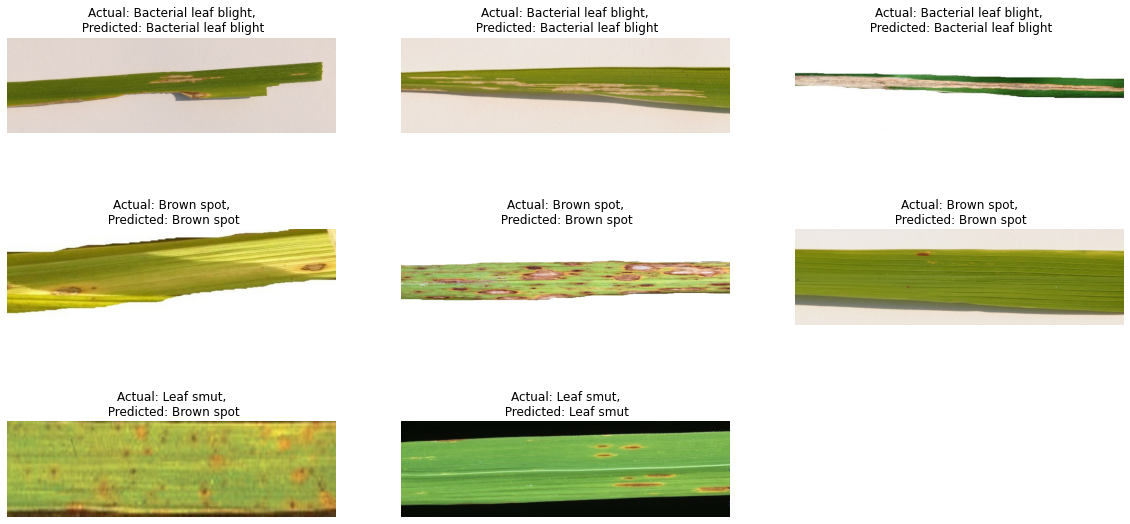

In [30]:
plt.figure(figsize=(20, 10))
for image_batch, labels_batch in test_data.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))                     # tensor 'image_batch' is converted in the range 0-255 pixels to display the images
        
        actual_class = class_names[labels_batch[i]]                            # gives the class name of actual class (label)
        
        prediction = model.predict(image_batch)                                # this gives the probability values for all classes (as softmax func is used)
        predicted_class = class_names[np.argmax(prediction[i])]                # this gives the class name (label) with maximum value which is the predicted class by the model
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}")
        
        plt.axis("off")

## Accuracy & Loss Graph for Training & Validation data

In [25]:
history.history.keys()                                          # list of parameters generated by model.fit() during training

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

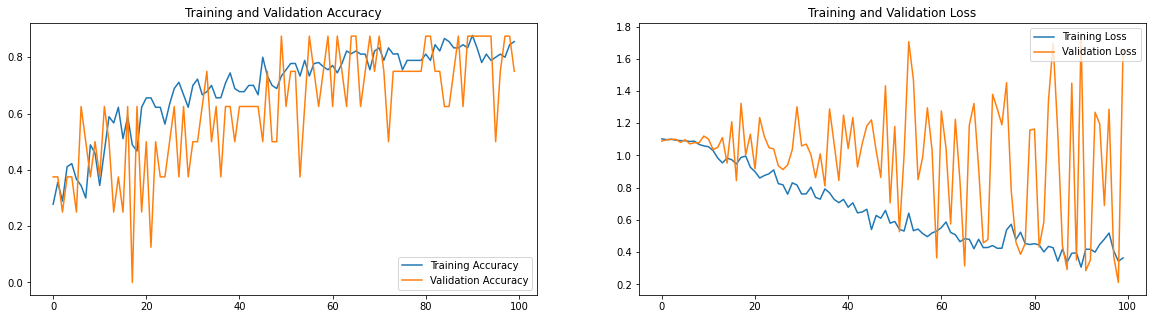

In [27]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)                                         # subplot 1 for 'Training and Validation Accuracy' graph
plt.plot(range(100), train_acc, label='Training Accuracy')   # range is (0-100) for 100 epochs
plt.plot(range(100), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)                                         # subplot 2 for 'Training and Validation Loss' graph
plt.plot(range(100), train_loss, label='Training Loss')
plt.plot(range(100), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save model

In [31]:
path = '/content/drive/MyDrive/Rice_leaf_disease_prediction_CNN_model.h5'
model.save(path)